In [1]:

#->IMPORTS

from google.colab import drive
import os
import pandas as pd
import time
from concurrent.futures import ProcessPoolExecutor
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

#-> LOAD THE DATASET
def load_dataset(file_path):
  if not os.path.exists(file_path):
    print("File not found")
  df=pd.read_csv(file_path)
  print('\nNo.of rows in the dataset:',len(df))
  print("Columns:", df.columns.tolist())
  text_cols = ['scheme_name', 'details', 'benefits', 'eligibility', 'tags']
  df['combined_text'] = df[text_cols].fillna('').agg(' '.join, axis=1)
  #empty cells get filled from NAN->" "(space)->''normal axis=1(column level)
  #E.g:["hello",NAN,""]->["Hello", "", "World"]  →  "Hello  World"
  return df

In [4]:
import re
#Pre-processing
def clean_text_regex(text):
    text = str(text).lower()                    # Convert to lowercase
    text = re.sub(r'[^a-z\s]', ' ', text)       # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()   # Removed extra spaces
    text = re.sub(r'http\S+|www\S+', '', text)   #Removed URLS
    return text


In [5]:
#SQL Part (function) FOR CREATING TABLES
import sqlite3

def create_tables(db_path="/content/drive/MyDrive/Infosys_Springboard_Project/themes.db"):
  conn=sqlite3.connect(db_path)
  cursor=conn.cursor() #Cursor helps to execute sql commands

  cursor.execute("""
  CREATE TABLE IF NOT EXISTS themes(
    theme_id INTEGER PRIMARY KEY,
    theme_name TEXT,
    keyword TEXT,
    UNIQUE(theme_name, keyword)
  );""") #TABLE themes created

  conn.commit()
  conn.close()
  print("Table created Successfully")

#FUNCTION FOR INSERTING THMES AND KEYWORDS INTO DATABSE
def insert_data(themes_dict,db_path="/content/drive/MyDrive/Infosys_Springboard_Project/themes.db"):
  conn=sqlite3.connect(db_path)
  cursor=conn.cursor()
  for theme_name1,keywords in themes_dict.items():
    for keyword1 in keywords:
      cursor.execute(
                "INSERT OR IGNORE INTO themes (theme_name, keyword) VALUES (?, ?)",
                (theme_name1, keyword1)
            )
  conn.commit()
  conn.close()
  print("DATA INSERTED SUCCESSFULLY")

#RESULTS TABLE
def results_table(db_path):
  conn=sqlite3.connect(db_path)
  cursor=conn.cursor()
  cursor.execute("""CREATE TABLE IF NOT EXISTS results_table(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    scheme_name TEXT,
    detected_themes TEXT
  )""")
  conn.commit()
  conn.close()

#INSERT DATA INTO RESULTS TABLE
def insert_into_results_table(df_with_themes,db_path):
  conn=sqlite3.connect(db_path)
  cursor=conn.cursor()
  for index,row in df_with_themes.iterrows():
    scheme_name=row["scheme_name"]
    detected_themes=','.join(row['detected_themes'])
    cursor.execute("INSERT OR IGNORE INTO results_table(scheme_name,detected_themes) VALUES(?,?) ",(scheme_name,detected_themes))
  conn.commit()
  conn.close()

#FETCHING DATA BACK TO CODE
def load_themes(db_path="/content/drive/MyDrive/Infosys_Springboard_Project/themes.db"):
    if not os.path.exists(db_path):
        print("Database file not found.")
        return {}

    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT theme_name, keyword FROM themes")
    rows = cursor.fetchall()
    conn.close()

    themes_dict = {}
    for theme, keyword in rows:
        if theme not in themes_dict: # loaded the themes into dictionary
            themes_dict[theme] = []
        themes_dict[theme].append(keyword)

    return themes_dict



In [6]:
#THEMES  & KEYWORDS NEED TO INSERT
def load_themes():
  themes = {
  "Education & Learning": [
    "AICTE","technical education","engineering college","polytechnic",
    "faculty training","faculty development","student training programme",
    "skill development programme","STTP", "education","educational","learning","school","higher education",
    "secondary education","academic","literacy","enrollment",
    "student","students pursuing","students enrolled","girl student",
    "university","college","educational institution","scholarship",
    "post matric scholarship","pre matric scholarship","matric scholarship",
    "scholarship portal","educational assistance","student financial assistance",
    "education loan","educational loan interest subsidy","fee reimbursement",
    "competitive exam","exam preparation","neet","jee","fellowship",
    "research fellowship","book allowance","learning enhancement programme"
],
  "Skills & Employment": [
    "skill development training","short term skill programme","vocational training initiative",
    "apprenticeship training programme","skill certification programme",
    "technical skill upgradation","industry aligned skill course",
    "employment linked training","job training","self employment",
    "upskilling","reskilling","workforce development",
    "placement assistance","internship","trainee",
    "iti","apprenticeship","unemployed youth",
    "job placement","skill workshop","skill enhancement",
    "technical training","skill institute","employment exchange",
    "unemployment allowance"
],

   "Business & Entrepreneurship": [
    "entrepreneurship development programme","startup assistance scheme","entrepreneur skill enhancement","innovation and incubation support",
    "incubation centre","msme cluster development","business expansion assistance","capital investment subsidy",
    "credit guarantee scheme","venture capital","startup fund","technology incubation","patent support","ipr support",
    "women entrepreneur","micro enterprise","small enterprise","medium enterprise","commercial production","working capital loan for business",
    "industrial promotion","cluster development scheme","export promotion scheme","trade facilitation scheme"
],

    "Sports": [
    "sports person","athlete","athletic","sports training","sports coaching","coaching camp","training camp","sports academy","sports excellence centre",
    "sports competition","sports tournament","national games","state level sports","sports award","sports scholarship","patnaik sports award","biju patnaik sports",
    "international sports","sports authority","recognized sports","sports disciplines","youth sports"
],
  }
  return themes



In [7]:
import re

def detect_themes(text):
  text = text.lower()
  themes_dict_global = load_themes()

  scores = {t: 0 for t in themes_dict_global}                 # scores → it gives scores when ever multi keywords appear in text
  longest = {t: 0 for t in themes_dict_global}                # longest → length of the biggest keyword matched

  for theme, keywords in themes_dict_global.items():          # theme → Education, Skill, Sports etc.
    for keyword in keywords:
      kw = keyword.lower().strip()                            # removes extra spaces from the keyword and line breaks

      ## MULTI-WORD KEYWORDS CHECK
      is_multi = bool(re.search(r"[\s\-\_/.,]", kw))          # → search for space or - or _ or , or / in keywords (self-employment)

      if is_multi:                                            # is multi keyword : yes
        if kw in text:                                        # example: "self employment" in text
          scores[theme] += 2                                  # scores['Skills & Employment'] += 2
          longest[theme] = max(longest[theme], len(kw))       # longest[...] = maximum length of matched keyword

      ## SINGLE-WORD → use word boundaries
      else:                                                   # SINGLE WORD
        pattern = rf"\b{re.escape(kw)}\b"
        if re.search(pattern, text):                          # exact match of the keyword in text
          scores[theme] += 1                                  # if it was single keyword adds 1
          longest[theme] = max(longest[theme], len(kw))       # update longest keyword matched for this theme

  # If no match return empty
  if max(scores.values()) == 0:
    return []

  # Choose best theme → score first, longest keyword second
  best = max(scores, key=lambda t: (scores[t], longest[t]))
  return [best]                                               # return only ONE best theme


In [8]:
#FREQUENCY OF DETECTED THEMES
def frequency_of_themes(dataframe):

  # Flatten the list of lists in 'detected_themes'
  all_detected_themes = [theme for sublist in dataframe['detected_themes'] for theme in sublist]
  # Count the frequency of each theme
  freq = Counter(all_detected_themes)
  return pd.DataFrame(freq.items(), columns=['Theme', 'Frequency'])




In [9]:
def plot_theme_bar_chart(theme_freq_df, save_path=None):
    theme_freq_df = theme_freq_df.sort_values("Frequency", ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(theme_freq_df['Theme'], theme_freq_df["Frequency"])
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


In [10]:
def plot_theme_pie_chart(theme_freq_df, save_path=None):
    plt.figure(figsize=(8,8))
    plt.pie(
        theme_freq_df["Frequency"],
        labels=theme_freq_df["Theme"],
        autopct="%1.1f%%",
        startangle=140
    )
    plt.title("Distribution of Detected Themes", fontsize=16)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print("Pie Chart saved at:", save_path)

    plt.show()


In [11]:
def final_pipeline():
  #LOAD DATASET
  df=load_dataset("/content/drive/MyDrive/Infosys_Springboard_Project/youth_schemes.csv")

  #CLEANING DATA [PRE-PROCESSSING]
  with ProcessPoolExecutor(max_workers=os.cpu_count()) as pool:
    #Used Parallel Processing
    cleaned_lines=list(pool.map(clean_text_regex,df['combined_text'],chunksize=1700))
  df['cleaned_text'] = cleaned_lines

  #LOAD_THEMES
  themes=load_themes()

  # 1.CREATE TABLE INSERT THEMES INTO IT
  create_tables()
  insert_data(themes)

  # 2.PARALLEL PROCESSING FOR THEME DETECTIO
  with ProcessPoolExecutor(max_workers=os.cpu_count()) as pool:
    theme_results = list(pool.map(detect_themes, df["cleaned_text"], chunksize=1000))

  df["detected_themes"] = theme_results

  # Filter the DataFrame to show only rows where 'detected_themes' is not an empty list unmatched keywords cant be fetched.

  df_with_themes = df[df['detected_themes'].apply(lambda x: len(x) > 0)]
  df_with_themes.reset_index(drop=True, inplace=True) #Make indexes start from 0,1,2,..
  #STORING RESULTS INTO DB FILE
  result_table_path="/content/drive/MyDrive/Infosys_Springboard_Project/detected_themes_results.db"
  results_table(result_table_path)
  insert_into_results_table(df_with_themes,result_table_path)

  # STORING RESULTS INTO CSV FILE
  df_csv = df_with_themes[["scheme_name", "detected_themes"]]
  csv_path = "/content/drive/MyDrive/Infosys_Springboard_Project/detected_themes_results.csv"
  df_csv.to_csv(csv_path, index=False, encoding="utf-8")
  return df_with_themes


No.of rows in the dataset: 3400
Columns: ['scheme_name', 'slug', 'details', 'benefits', 'eligibility', 'application', 'documents', 'level', 'schemeCategory', 'Unnamed: 9', 'tags']
Table created Successfully
DATA INSERTED SUCCESSFULLY
                         Theme  Frequency
0         Education & Learning       1192
1  Business & Entrepreneurship        252
2          Skills & Employment        205
3                       Sports         24


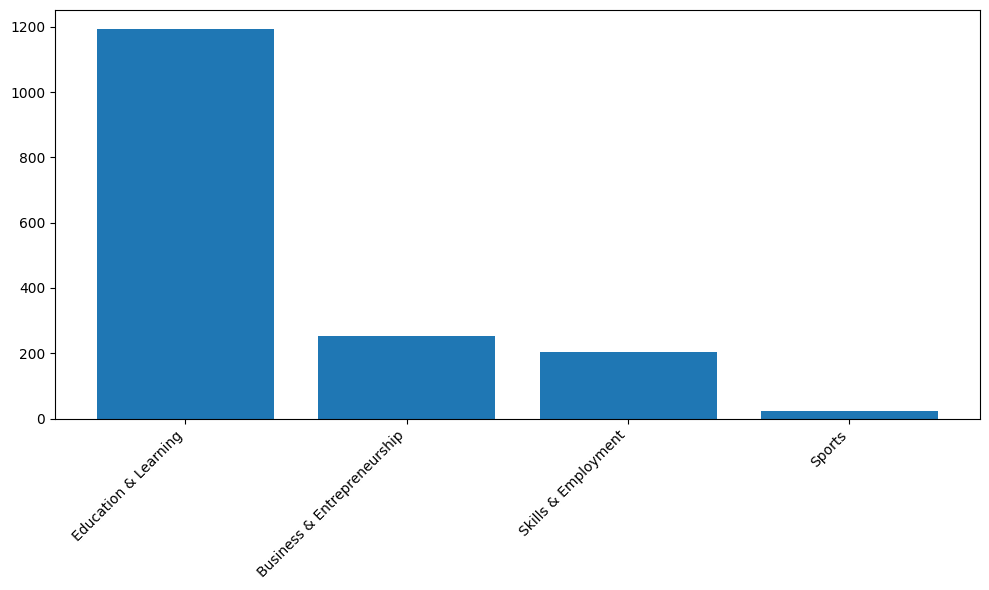

In [12]:
df_with_themes=final_pipeline()
freq=frequency_of_themes(df_with_themes)
print(freq)
plot_theme_bar_chart(freq)




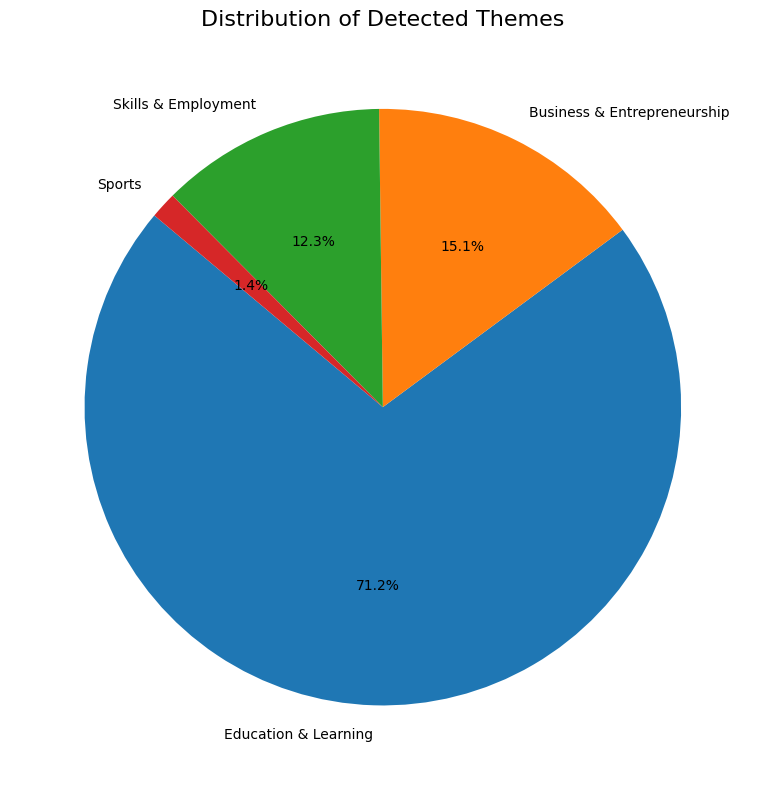

In [13]:
plot_theme_pie_chart(freq)